In [1]:
import mxnet as mx
from mxnet import gluon, nd
import gluonnlp as gnlp
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn
from tqdm import tqdm
import numpy as np
import pandas as pd
import re

/opt/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_dataset_raw, test_dataset_raw = [gnlp.data.IMDB(root='data/imdb', segment=segment)
                               for segment in ('train', 'test')]

In [2]:
import time
import multiprocessing as mp
length_clip = gnlp.data.ClipSequence(500)

In [4]:
# from : https://gluon-nlp.mxnet.io/api/notes/data_api.html

# Dataset preprocessing
import spacy

nlp = spacy.load("en")


def preprocess(x):
    data, label = x
    # In the labeled train/test sets, a negative review has a score <= 4
    # out of 10, and a positive review has a score >= 7 out of 10. Thus
    # reviews with more neutral ratings are not included in the train/test
    # sets. We labeled a negative review whose score <= 4 as 0, and a
    # positive review whose score >= 7 as 1. As the neural ratings are not
    # included in the datasets, we can simply use 5 as our threshold.
    label = int(label > 5)
    data = nlp(data)
    data = length_clip([token.lemma_ for token in data if not token.is_stop])
    return data, label, x


def preprocess_dataset(dataset):
    start = time.time()
    pool = mp.Pool()
    dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
    end = time.time()
    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset

# Preprocess the dataset
train_dataset_tkn = preprocess_dataset(train_dataset_raw)
test_dataset_tkn = preprocess_dataset(test_dataset_raw)


/opt/venv/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/opt/venv/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]


Done! Tokenizing Time=1227.40s, #Sentences=25000
Done! Tokenizing Time=1220.25s, #Sentences=25000


In [5]:
#import pickle 

#pickle.dump([train_dataset_tkn, test_dataset_tkn], open('nouns.pkl', 'wb'))

In [4]:
#import pickle 

#with open('nouns.pkl','rb') as f:
#     train_dataset_tkn, test_dataset_tkn = pickle.load(f)


In [104]:
#import pickle 
#pickle.dump([train_dataset, test_dataset], open("nouns.pkl", 'wb'))

In [5]:
import itertools
train_seqs = [sample[0] for sample in train_dataset_tkn]
counter = gnlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))
vocab = gnlp.Vocab(counter, max_size=10000)
print(vocab)



Vocab(size=10004, unk="<unk>", reserved="['<pad>', '<bos>', '<eos>']")


In [6]:
def token_to_idx(x):
    return vocab[x[0]], x[1]

pool = mp.Pool()
train_dataset = pool.map(token_to_idx, train_dataset_tkn)
test_dataset = pool.map(token_to_idx, test_dataset_tkn)
pool.close()
print(train_dataset[0][0][:50])


[0, 161, 672, 106, 5, 6, 145, 22, 1400, 269, 51, 4, 7, 1221, 7, 5, 6, 4127, 60, 6297, 4942, 140, 129, 0, 161, 17, 1669, 296, 476, 7, 1221, 7, 5, 13, 0, 1002, 9063, 4, 5161, 663, 113, 1054, 1221, 21, 0, 4, 0, 442, 4, 600]


In [8]:
batchify_fn = gnlp.data.batchify.Tuple(gnlp.data.batchify.Pad(axis=0),
                                       gnlp.data.batchify.Stack(), 
                                       gnlp.data.batchify.Stack())

In [9]:
train_dataset_new = []
for i, (x, y) in enumerate(train_dataset):
    train_dataset_new.append([x,y,i])
    
test_dataset_new = []
for i, (x, y) in enumerate(test_dataset):
    test_dataset_new.append([x,y,i])
    

In [13]:
train_dataloader = gluon.data.DataLoader(dataset=train_dataset_new,
                                         shuffle=True,
                                         batchify_fn=batchify_fn, batch_size=100)
test_dataloader = gluon.data.DataLoader(dataset=test_dataset_new,
                                        shuffle=True,
                                        batchify_fn=batchify_fn, batch_size=100)


In [14]:
fasttext_en = gnlp.embedding.create('fasttext', source='wiki.en')

vocab.set_embedding(fasttext_en)

In [15]:
in_vocab_size, out_vocab_size = vocab.embedding.idx_to_vec.shape

In [61]:
class SentClassificationModel(gluon.Block):
    def __init__(self, in_vocab_size, out_vocab_size, **kwargs):
        super(SentClassificationModel, self).__init__(**kwargs)
        with self.name_scope():
            self.embed = nn.Embedding(input_dim=in_vocab_size, output_dim=out_vocab_size)
            self.conv1 = nn.Conv1D(32, 1, padding=0)
            self.conv2 = nn.Conv1D(16, 2, padding=1)
            self.conv3 = nn.Conv1D(8,  3, padding=1)
            self.pool1 = nn.GlobalAvgPool1D()
            self.pool2 = nn.GlobalAvgPool1D()
            self.pool3 = nn.GlobalAvgPool1D()
            self.dense = nn.Dense(2)
            self.conv1_act = None

    def forward(self, inputs):
        em_out = self.embed(inputs)
        em_swaped = nd.swapaxes(em_out, 1,2)
        self.conv1_act = self.conv1(em_swaped)            
        conv1_out = self.pool1(self.conv1_act)
        conv2_ = self.conv2(em_swaped)
        conv2_out = self.pool2(conv2_)
        conv3_ = self.conv3(em_swaped)
        conv3_out = self.pool3(conv3_)
        cated_layer = nd.concat(conv1_out, conv2_out, conv3_out, dim=1)
        outs = self.dense(cated_layer)
        return outs

In [63]:
ctx = mx.gpu()

model = SentClassificationModel(in_vocab_size, out_vocab_size)
model.initialize(mx.init.Xavier(), ctx=ctx)
model.embed.weight.set_data(vocab.embedding.idx_to_vec.as_in_context(ctx))
trainer = gluon.Trainer(model.collect_params(),'adam')
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [64]:
model(nd.random.normal(0,1, (1, 500), ctx=ctx))


[[0. 0.]]
<NDArray 1x2 @gpu(0)>

In [65]:
def evaluate(net, data_iter, ctx):
    acc = mx.metric.Accuracy()
    for i, (data_x, data_y, _) in enumerate(data_iter):
        data_x = data_x.as_in_context(ctx)
        output = net(data_x)
        acc.update(data_y, output)
    return acc.get()[1]

In [66]:
epochs = 2

tot_train_loss = []
for e in range(epochs):
    train_loss = []
    for i, (data, label, _) in enumerate(tqdm(train_dataloader)):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = model(data)
            loss_ = loss(output, label)
            loss_.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss_).asscalar()
        train_loss.append(curr_loss)
    train_acc = evaluate(model, train_dataloader, ctx)
    test_acc  = evaluate(model, test_dataloader, ctx)
    print("Epoch %s. Train Loss: %s, Train Accuracy : %s, Test Accuracy : %s" % 
          (e, np.mean(train_loss), train_acc, test_acc))    
    tot_train_loss.append(np.mean(train_loss))

  1%|          | 2/250 [00:00<00:13, 18.78it/s]

Epoch 0. Train Loss: 0.47437936, Train Accuracy : 0.89568, Test Accuracy : 0.86308


100%|██████████| 250/250 [00:13<00:00, 18.45it/s]


Epoch 1. Train Loss: 0.25984132, Train Accuracy : 0.9318, Test Accuracy : 0.87508


In [142]:
def grad_cam_conv1D(model, x, y, loss, ctx):
    with autograd.record(train_mode=False):
        output = model(nd.array([x,],ctx=ctx))
        loss_ = loss(output, nd.array([y,],ctx=ctx))
        output = nd.SoftmaxActivation(output)
        print(output)
        loss_.backward()
    acts = model.conv1_act
    #a_k^c
    global_avg_grad = nd.mean(model.conv1.weight.grad(), axis=(1,2))
    #L_{Grad-CAM}^c
    for i in range(acts.shape[1]):
        acts[:,i,:] *= global_avg_grad[i]
    heat = nd.relu(nd.sum(acts, axis=1))
    return(heat.asnumpy()[0], loss_)


In [123]:
preds = []
labels = []
raw_idx = []
for data, label, i in test_dataloader:
    pred = nd.SoftmaxActivation(model(data.as_in_context(ctx)))
    preds.append(pred)
    labels.append(label)
    raw_idx.append(i)

res = nd.concat(*preds, dim=0)
reslab = nd.concat(*labels, dim=0)

In [124]:
prob_np = res.asnumpy()

In [125]:
prob_np_a = prob_np[:,1]
test_y = reslab.asnumpy()

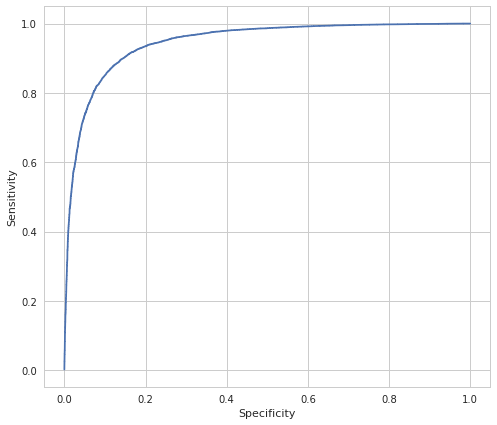

AUC: 0.9455451392


In [141]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 15})
plt.figure(figsize=(8,7))


y_true = test_y
y_probas = prob_np_a
fpr, tpr, thresholds = metrics.roc_curve(1 - y_true, y_probas, pos_label=0)

# Print ROC curve
plt.plot(fpr, tpr)
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.savefig('auc.png', dpi=300)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)


In [133]:
for data, label, i in test_dataloader:
    data_x = data
    pred = nd.SoftmaxActivation(model(data_x.as_in_context(ctx)))
    labels = label
    idx_list = i
    break


In [134]:
idx = 10
pred[idx], data_x[idx], labels[idx], test_dataset_tkn[int(idx_list[idx].asnumpy()[0])]

(
 [0.9917772  0.00822277]
 <NDArray 2 @gpu(0)>, 
 [ 104   26    0    0    6 1469  778   25    4   12  288   96   12  397
     0  611    0 2314    5  967  726  595    0    4  100    0    0  453
    15 3376  495   16 2835    8   49    5  398    4 2135 2074  559    8
  2639    4 1722 6319    0    0    5   80    0  495   17 1164    4  842
  1803    0    4  239 3698    5  495    4   41 4071   17  558    0   60
     4    0 1093    7  312    0 2137    7    4    0   10    0   15 3769
    16    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   

In [143]:
heat, loss_val = grad_cam_conv1D(model, data_x[idx].asnumpy(), np.argmax(pred[idx].asnumpy()), loss=loss, ctx=ctx)


[[0.9917772  0.00822277]]
<NDArray 1x2 @gpu(0)>


In [144]:
hm_tbl = pd.DataFrame({'heat':heat, 'kw':[vocab.to_tokens(int(i)) for i in data_x[idx].asnumpy()]})

In [145]:
hm_tbl.drop_duplicates(inplace=True)
hm_tbl.sort_values(by='heat', inplace=True, ascending=False)

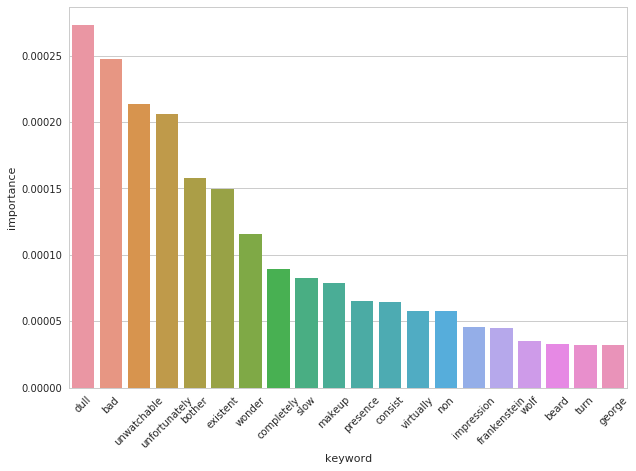

In [146]:
import seaborn as sns
sns.set(style="whitegrid")
rcParams.update({'font.size': 17})
plt.figure(figsize=(10,7))

ax = sns.barplot(x="kw", y="heat", data=hm_tbl[:20])
plt.xticks(rotation=45)
plt.ylabel('importance')
plt.xlabel('keyword')
plt.savefig('importances.png', dpi=300)